## **Consuming a Python Model from a C# Client**

---
As we discussed earlier in this article, integrating machine learning models developed in Python into applications written in other programming languages, such as C#, is not a straightforward task due to the inability to directly call Python functions from C#. However, one effective approach is to wrap the Python model in a web service and expose its prediction methods (e.g., predict or predict_proba) via a REST API. This allows applications written in different languages to interact seamlessly with the Python-based model.

In this section, we will focus on training a model using the well-known Titanic dataset, which is available on Kaggle here. Once the model is trained, we will demonstrate how to consume it in a C# application by setting up a web service using Flask, a popular Python framework designed for creating web applications and services.

To proceed, ensure Flask is installed on your system. Then, create a Python file named app.py and insert the following code. This code will set up a Python-based web service listening on port 5000, providing an easy way to call the Titanic survival prediction model from any external application, including one developed in C#:


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from flask import Flask, request


In [4]:
df=pd.read_csv('/content/drive/MyDrive/FORMATION ML/titanic.csv')

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.shape

(891, 12)

The dataset consists of 891 rows and 12 columns. Some columns, such as PassengerId and Name, are not relevant for a machine learning model, while others are crucial. We will focus on the following:

Survived: Indicates whether the passenger survived the disaster (1) or not (0).
Pclass: Represents the passenger’s travel class: first (1), second (2), or third (3).
* Sex: Indicates the passenger’s gender.
* Age: Indicates the passenger’s age.

The Survived column serves as the target variable—the one we aim to predict. The other columns are relevant because first-class passengers had a higher chance of survival, as their cabins were closer to the upper deck and lifeboats. Additionally, women and children were given priority for lifeboat spaces.

To check if the dataset contains any missing values, use the following command:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The Cabin column has many missing values, but since we won’t be using it, we can ignore them. However, the Age column also contains some missing values. One approach, known as imputing missing values, would be to fill them with the mean age, but we’ll take a simpler route and remove rows with missing values.



As a reminder, machine learning models only work with numerical values, while the Sex column contains "Male" and "Female," which data scientists refer to as categorical data.

There are several techniques to convert categorical data into numerical data, including Label Encoding and One-Hot Encoding. However, we won’t cover them in detail here. I will write a dedicated article specifically on handling categorical data.


The following commands will drop unnecessary columns, remove rows with missing values, and apply one-hot encoding to the Sex and Pclass columns:

In [8]:
df = df[['Survived', 'Age', 'Sex', 'Pclass']]
df = pd.get_dummies(df, columns=['Sex', 'Pclass'])
df.dropna(inplace=True)
df = df.astype(int)
df.head()

,Survived,Age,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22,0,1,0,0,1
1,1,38,1,0,1,0,0
2,1,26,1,0,0,0,1
3,1,35,1,0,1,0,0
4,0,35,0,1,0,0,1


The next task is to split the dataset for training and testing:

In [9]:
x = df.drop('Survived', axis=1)
y = df['Survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,stratify=y, random_state=0)

Now create a logistic regression model, train it with the data split off for training, and score it with the test data:

In [10]:
model = LogisticRegression(random_state=0)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.8321678321678322

Re-evaluate the model using cross-validation to gain more confidence in the score. Remember that this is the accuracy score, calculated by summing the true positives and true negatives, then dividing by the total number of samples:

In [11]:
cross_val_score(model, x, y, cv=5).mean()

0.7843494533635378

Use the following commands to generate a confusion matrix that clearly shows the model's performance during testing:

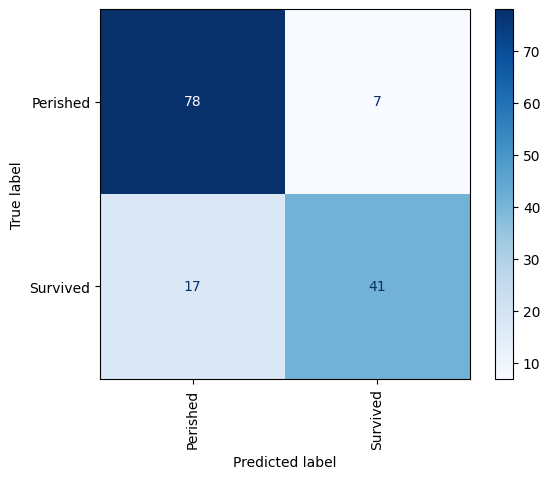

In [12]:
cmd.from_estimator(model, x_test, y_test, display_labels=['Perished', 'Survived'],
cmap='Blues', xticks_rotation='vertical')

Now, let's use the trained model to make predictions. First, let's determine if a 30-year-old female traveling in first class is likely to survive the voyage. Since the model was trained with a DataFrame containing specific column names, we'll use the same column names to create the input:

In [13]:
female = pd.DataFrame({ 'Age': [30], 'Sex_female': [1], 'Sex_male': [0], 'Pclass_1': [1], 'Pclass_2': [0], 'Pclass_3': [0] })
model.predict(female)[0]

1

The model predicts she will survive, but what are the odds that she we will survive?

In [14]:
probability = model.predict_proba(female)[0][1]
print(f'Probability of survival: {probability:.1%}')

Probability of survival: 91.6%


Now, we will save our model, knowing that we can always improve its performance, but that is not the goal of this article.

In [15]:
with open("model.pkl", "wb") as file:
    pickle.dump(model, file)
print("Model saved successfully!")

Model saved successfully!


Suppose you want to invoke our previously trained model on the Titanic dataset, which is saved, from an app written in another language, such as C#. You can't directly call a Python function from C#, but you can wrap the Python model in a web service and expose its predict (or predict_proba) method using a REST API. One way to build this web service is by using Flask, a popular Python framework for creating websites and web services.


To try it out, ensure that Flask is installed on your computer. Next, create a file called app.py and paste the following code. This code uses Flask to set up a Python web service that listens on port 5000:

In [ ]:
 # Initialize Flask app
app = Flask(__name__)

# Load the saved model
model = pickle.load(open('/content/model.pkl', 'rb'))

@app.route('/predict', methods=['GET'])
def predict():
    if 'age' in request.args and 'sex' in request.args and 'pclass' in request.args:
        age = float(request.args.get('age'))
        sex = request.args.get('sex').lower()
        pclass = int(request.args.get('pclass'))

        # Prepare input data
        sex_female = 1 if sex == 'female' else 0
        sex_male = 1 if sex == 'male' else 0
        pclass_1 = 1 if pclass == 1 else 0
        pclass_2 = 1 if pclass == 2 else 0
        pclass_3 = 1 if pclass == 3 else 0

        input_data = pd.DataFrame({
            'Age': [age],
            'Sex_female': [sex_female],
            'Sex_male': [sex_male],
            'Pclass_1': [pclass_1],
            'Pclass_2': [pclass_2],
            'Pclass_3': [pclass_3]
        })

        prediction = model.predict(input_data)[0]
        probabilities = model.predict_proba(input_data)[0]

        if prediction == 1:
            result = f"Survival Prediction: Survived (Probability: {probabilities[1]:.2f})"
        else:
            result = f"Survival Prediction: Not Survived (Probability: {probabilities[0]:.2f})"

        result += f"\nProbabilities for all classes: [Not Survived: {probabilities[0]:.2f}, Survived: {probabilities[1]:.2f}]"
        return result

    else:
        return "Missing parameters. Please provide age, sex, and pclass."

if __name__ == '__main__':
    app.run(debug=True, port=5000, host='0.0.0.0')


 Upon startup, the service loads the pipeline with the Titanic model from the model.pkl file. The @app.route decorator for the predict function tells Flask to execute this function when the service’s /predict endpoint is called.

When the service is running locally and a POST request with JSON data is sent to this endpoint, the request body is expected to contain a JSON payload. This JSON data should include the passenger's age, sex, and pclass. The predict function processes this input, runs it through the model, and returns a JSON response indicating whether the passenger survived or not, along with the probability of survival.


Postman is a tool used for testing and interacting with APIs. It allows developers to send various types of HTTP requests (like GET, POST, PUT, DELETE) to web services, view responses, and debug issues. Postman supports different data formats such as JSON and XML, making it useful for testing and developing APIs.

Once the application is running, you can test it by sending a request using Postman.



Here the output:

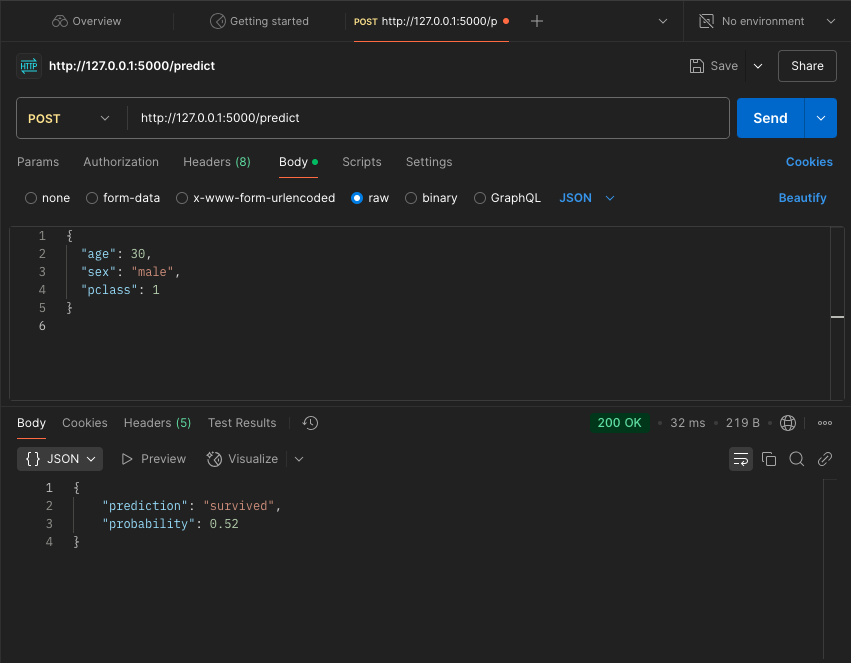

To demonstrate, navigate to the directory containing app.py (ensuring that model.pkl is also present) and start Flask by running:


```
python app.py
```


flask run
Next, open a separate command prompt and use a curl command to send a request to the URL.



```
curl -X POST http://127.0.0.1:5000/predict -H "Content-Type: application/json" -d '{"age": 30, "sex": "male", "pclass": 1}'



```
Here's the output



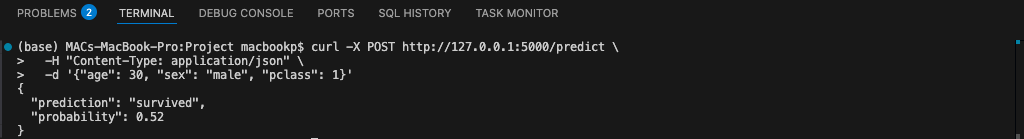

If you have Visual Studio or Visual Studio Code installed and configured to compile and run C# applications, you can use the following C# console app code to call the web service and analyze the sentiment of a text string. However, you're not restricted to using C#—you can invoke the web service (and the model) from any programming language, as most modern languages support sending HTTP requests.

In [ ]:
#Code Written in C#
using System;
using System.Net.Http;
using System.Text;
using System.Threading.Tasks;
using Newtonsoft.Json;

class Program
{
    static async Task Main(string[] args)
    {
        // Get the input data (age, sex, pclass)
        Console.Write("Enter age: ");
        var age = Console.ReadLine();

        Console.Write("Enter sex (male/female): ");
        var sex = Console.ReadLine();

        Console.Write("Enter pclass (1, 2, or 3): ");
        var pclass = Console.ReadLine();

        // Validate and ensure correct types for the input
        if (!int.TryParse(age, out int ageParsed))
        {
            Console.WriteLine("Invalid age input.");
            return;
        }

        if (!int.TryParse(pclass, out int pclassParsed) || (pclassParsed < 1 || pclassParsed > 3))
        {
            Console.WriteLine("Invalid pclass input. Please enter a value between 1 and 3.");
            return;
        }

        if (sex != "male" && sex != "female")
        {
            Console.WriteLine("Invalid sex input. Please enter 'male' or 'female'.");
            return;
        }

        // Prepare the data to send to the Flask app in JSON format
        var inputData = new
        {
            age = ageParsed,
            sex = sex,
            pclass = pclassParsed
        };

        // Convert the input data to JSON
        string jsonInput = JsonConvert.SerializeObject(inputData);

        // Create HttpClient instance to send the POST request
        var client = new HttpClient();
        var url = "http://127.0.0.1:5000/predict";  // Flask app URL

        // Send the POST request with JSON data
        var response = await client.PostAsync(url,
            new StringContent(jsonInput, Encoding.UTF8, "application/json"));

        // Check if the request was successful
        if (response.IsSuccessStatusCode)
        {
            // Read and display the response from Flask
            var responseString = await response.Content.ReadAsStringAsync();
            Console.WriteLine("Prediction Response: " + responseString);
        }
        else
        {
            Console.WriteLine("Error: Unable to get a valid response from the server.");
        }
    }
}


Here's the output:

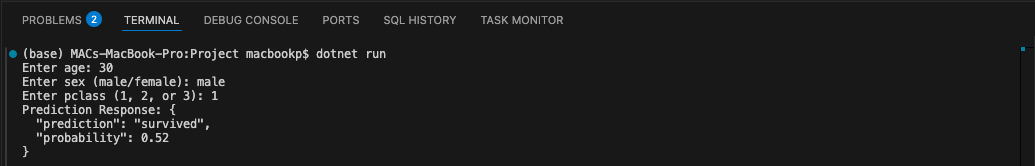